## Social Network Moderator Prediction

This is a study in exploratory data analysis and in building of a regression model for the following problem.

Given only the boundaries of frames generated by users (and ground-truth boundaries as train answers) we need to predict the real boundaries of objects in photos. The photos themselves are not provided.

## Contents

1. [Getting the data](#Getting-the-data)
2. [Ideas](#Ideas)
3. [EDA: Coordinates](#EDA:-Coordinates)
4. [EDA: Trusted and non-trusted users](#EDA:-Trusted-and-non-trusted-users)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Getting the data

`votes` — boundaries provided by users; fields = {`userId`, `itemId`, `Xmin`, `Xmax`, `Ymin`, `Ymax`}

`answers` — ground-truth boundaries; fields = {`itemId`, `Xmin_true`, `Xmax_true`, `Ymin_true`, `Ymax_true`}

In [2]:
votes = pd.read_csv('train_data.csv')
votes.rename(columns={
    'Xmin': 'x1',
    'Xmax': 'x2',
    'Ymin': 'y1',
    'Ymax': 'y2'
}, inplace=True)

answers = pd.read_csv('train_answers.csv')
answers.rename(columns={
    'Xmin_true': 'x1_t',
    'Xmax_true': 'x2_t',
    'Ymin_true': 'y1_t',
    'Ymax_true': 'y2_t'
}, inplace=True)

questions = pd.read_csv('test_data.csv')
questions.rename(columns={
    'Xmin': 'x1',
    'Xmax': 'x2',
    'Ymin': 'y1',
    'Ymax': 'y2'
}, inplace=True)

A frame is described with 4 lines: `x1`, `x2`, `y1`, and `y2`.

**I will call them either lines, coordinates, or boundaries.**

### Ideas

* find the centers of predicted boundaries and look how they deviate from the centers of target boundaries
* find the deviation of each separate coordinate
* look for biases in user predictions (shift in any direction, always wider frames, etc)
* trusted and non-trusted users (even for each coordinate separately)

### EDA: Coordinates

First, let's play with pure coordinates (independently of users).

#### Step 1

Find the mean lines for every prediction and for target boundaries, then merge them on `itemId`.

In [3]:
coords_p = votes.copy()
mean_xs_p = (coords_p.x1 + coords_p.x2) / 2
mean_ys_p = (coords_p.y1 + coords_p.y2) / 2

coords_p['mean_x'] = mean_xs_p
coords_p['mean_y'] = mean_ys_p

coords_t = answers.copy()
mean_xs_t = (coords_t.x1_t + coords_t.x2_t) / 2
mean_ys_t = (coords_t.y1_t + coords_t.y2_t) / 2

coords_t['mean_x_t'] = mean_xs_t
coords_t['mean_y_t'] = mean_ys_t

coords = coords_p.merge(coords_t, on='itemId', how='outer')

In [4]:
coords.head()

,userId,itemId,x1,y1,x2,y2,mean_x,mean_y,x1_t,y1_t,x2_t,y2_t,mean_x_t,mean_y_t
0,1164,6132,62,656,276,803,169.0,729.5,47,650,213,812,130.0,731.0
1,1399,6132,184,662,235,740,209.5,701.0,47,650,213,812,130.0,731.0
2,1694,6132,63,648,272,830,167.5,739.0,47,650,213,812,130.0,731.0
3,916,6132,111,637,253,831,182.0,734.0,47,650,213,812,130.0,731.0
4,1621,6132,60,651,242,819,151.0,735.0,47,650,213,812,130.0,731.0


#### Step 2

Get the *mean values of the mean predicted coordinates* (centroids of predicted central lines) and apply whatever *non-changing* function to the mean target coordinates (they are the same for any given `itemId`, so almost any function will do, I've chosen `max`).

In [5]:
mean_coords = coords.groupby('itemId', as_index=False).agg({
    'mean_x': 'mean',
    'mean_y': 'mean',
    'mean_x_t': 'max',
    'mean_y_t': 'max'
})

In [6]:
mean_coords.head()

,itemId,mean_x,mean_y,mean_x_t,mean_y_t
0,5,342.833333,1083.666667,423.5,1083.5
1,10,252.000000,709.000000,229.5,726.0
2,13,333.166667,784.833333,427.5,809.0
3,30,180.300000,412.400000,195.0,449.0
4,32,142.166667,656.416667,179.0,674.5


#### Step 3

Calculate the distances between mean predicted X/Y boundaries and true X/Y boundaries. Also, calculate the distance between mean central points of predicted boundaries and central points of the true ones.

In [7]:
x_distances = abs(mean_coords.mean_x - mean_coords.mean_x_t)
y_distances = abs(mean_coords.mean_y - mean_coords.mean_y_t)
centers_distances = np.sqrt(
    (mean_coords.mean_x - mean_coords.mean_x_t)**2 +
    (mean_coords.mean_y - mean_coords.mean_y_t)**2
)

mean_coords['x_distance'] = x_distances
mean_coords['y_distance'] = y_distances
mean_coords['centers_distance'] = centers_distances

In [8]:
distances = mean_coords.drop(columns=['mean_x', 'mean_y', 'mean_x_t', 'mean_y_t'])

In [9]:
distances.head()

,itemId,x_distance,y_distance,centers_distance
0,5,80.666667,0.166667,80.666839
1,10,22.500000,17.000000,28.200177
2,13,94.333333,24.166667,97.379698
3,30,14.700000,36.600000,39.441729
4,32,36.833333,18.083333,41.032931


#### Step 4

See how distances correlate for X and Y dimensions. Both *mean*, *max* and quantile values for `y_distance` are consistently smaller than those for `x_distance`. Probably means that human error is more horizontally oriented.

Also, there seems to be a case with predictions exactly matching the ground-truth boundaries for at least one item (`distance` equals 0). Though a frame may be bigger or smaller but all boundaries are equidistant from center.

In [10]:
distances.describe()

,itemId,x_distance,y_distance,centers_distance
count,943.000000,943.000000,943.000000,943.000000
mean,18262.242842,41.297174,34.372718,60.113164
std,10419.986333,43.479992,37.205217,50.470926
min,5.000000,0.000000,0.000000,0.000000
25%,9328.000000,9.277778,7.591667,22.162708
50%,18750.000000,26.625000,22.333333,46.313594
75%,27326.500000,58.841667,47.190972,86.146615
max,35962.000000,325.250000,231.333333,329.560052


#### Step 5

Now let's calculate distances for separate boundaries (between the mean of each predicted coordinate and the target coordinate).

In [11]:
coords.head()

,userId,itemId,x1,y1,x2,y2,mean_x,mean_y,x1_t,y1_t,x2_t,y2_t,mean_x_t,mean_y_t
0,1164,6132,62,656,276,803,169.0,729.5,47,650,213,812,130.0,731.0
1,1399,6132,184,662,235,740,209.5,701.0,47,650,213,812,130.0,731.0
2,1694,6132,63,648,272,830,167.5,739.0,47,650,213,812,130.0,731.0
3,916,6132,111,637,253,831,182.0,734.0,47,650,213,812,130.0,731.0
4,1621,6132,60,651,242,819,151.0,735.0,47,650,213,812,130.0,731.0


The same as before, let's get the `mean` of the predicted coords and the `max` of the identical target coords (the latter ones are always the same).

In [12]:
separate_mean_coords = coords.groupby('itemId').agg({
    'x1': 'mean',
    'x2': 'mean',
    'y1': 'mean',
    'y2': 'mean',
    'x1_t': 'max',
    'x2_t': 'max',
    'y1_t': 'max',
    'y2_t': 'max'
})

In [13]:
x1_distances = abs(separate_mean_coords.x1 - separate_mean_coords.x1_t)
x2_distances = abs(separate_mean_coords.x2 - separate_mean_coords.x2_t)
y1_distances = abs(separate_mean_coords.y1 - separate_mean_coords.y1_t)
y2_distances = abs(separate_mean_coords.y2 - separate_mean_coords.y2_t)

separate_mean_coords['x1_distance'] = x1_distances
separate_mean_coords['x2_distance'] = x2_distances
separate_mean_coords['y1_distance'] = y1_distances
separate_mean_coords['y2_distance'] = y2_distances

In [14]:
separate_distances = separate_mean_coords.drop(columns=['x1', 'x2', 'y1', 'y2', 'x1_t', 'x2_t', 'y1_t', 'y2_t'])

In [15]:
separate_distances.head()

,x1_distance,x2_distance,y1_distance,y2_distance
itemId,,,,
5,13.666667,147.666667,91.666667,91.333333
10,61.666667,16.666667,42.333333,8.333333
13,163.333333,25.333333,95.000000,46.666667
30,30.400000,59.800000,2.400000,70.800000
32,1.833333,71.833333,20.000000,56.166667


#### Step 6

We can see that the `y1` coordinate is the least biased (~25% less than others).

In [16]:
separate_distances.describe()

,x1_distance,x2_distance,y1_distance,y2_distance
count,943.000000,943.000000,943.000000,943.000000
mean,61.157989,70.516148,40.891273,63.877593
std,63.941687,71.681387,43.638431,70.249099
min,0.000000,0.000000,0.000000,0.000000
25%,14.136364,17.000000,8.633333,12.944444
50%,40.200000,45.600000,26.000000,40.000000
75%,85.937500,101.111111,59.000000,87.354167
max,407.400000,426.375000,301.100000,396.900000


#### Step 7

Let's find the correlation of predicted width and height of frames and those of the target ones. First, we'll do that for the whole set, then we'll look separately at vertically and horizontally oriented frames.

In [17]:
frames = votes.drop(columns=['userId']).merge(answers, on='itemId', how='outer')

In [18]:
widths = frames.x2 - frames.x1
widths_t = frames.x2_t - frames.x1_t
widths_diff = widths - widths_t

heights = frames.y2 - frames.y1
heights_t = frames.y2_t - frames.y1_t
heights_diff = heights - heights_t

frames['width'] = widths
frames['width_t'] = widths_t
frames['width_diff'] = widths_diff

frames['height'] = heights
frames['height_t'] = heights_t
frames['height_diff'] = heights_diff

In [19]:
frames.head()

,itemId,x1,y1,x2,y2,x1_t,y1_t,x2_t,y2_t,width,width_t,width_diff,height,height_t,height_diff
0,6132,62,656,276,803,47,650,213,812,214,166,48,147,162,-15
1,6132,184,662,235,740,47,650,213,812,51,166,-115,78,162,-84
2,6132,63,648,272,830,47,650,213,812,209,166,43,182,162,20
3,6132,111,637,253,831,47,650,213,812,142,166,-24,194,162,32
4,6132,60,651,242,819,47,650,213,812,182,166,16,168,162,6


If `width_diff < 0` then predicted frame is more narrow than the target frame (horizontally, of course). If `width_diff > 0` then it's wider. The same applies to `height_diff`, only for vertical measurements.

By the way, what's the ratio of vertically oriented frames to horizontally oriented ones? Oh, even square frames do exist...

In [20]:
total_amount = len(frames)
v_amount = len(frames[frames.width_t < frames.height_t])
h_amount = len(frames[frames.width_t > frames.height_t])
s_amount = len(frames[frames.width_t == frames.height_t])

{
    'vertical_to_all': [v_amount, v_amount / total_amount],
    'horizontal_to_all': [h_amount, h_amount / total_amount],
    'square_to_all': [s_amount, s_amount / total_amount]
}

{'vertical_to_all': [1252, 0.2345887202548248],
 'horizontal_to_all': [3987, 0.7470489038785835],
 'square_to_all': [98, 0.01836237586659172]}

#### Step 8

Well, let's make a clean dataset for the size-related data only.

In [21]:
sizes = frames.drop(columns=['x1', 'x2', 'y1', 'y2', 'x1_t', 'x2_t', 'y1_t', 'y2_t'])

Now let's look at the stats in general.

In [22]:
mean_size_diffs = sizes.groupby('itemId').agg({
    'width_diff': 'mean',
    'height_diff': 'mean'
})

Here we clearly see that more than a half of all predictions are smaller than the target frames. When it's time to remove spikes from small number of predictions, it may be a decent strategy to remove those which predict greater frames.

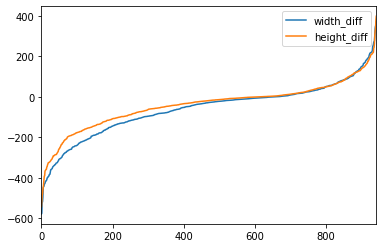

In [23]:
mean_size_diffs.sort_values('width_diff').reset_index().width_diff.plot(legend=True)
mean_size_diffs.sort_values('height_diff').reset_index().height_diff.plot(legend=True)

In [24]:
mean_size_diffs.describe()

,width_diff,height_diff
count,943.000000,943.000000
mean,-59.384804,-39.910450
std,134.075605,115.469463
min,-578.200000,-542.285714
25%,-125.916667,-95.976190
50%,-28.000000,-18.571429
75%,10.545455,14.500000
max,370.333333,397.666667


#### Step 9

Now let's take a look at the same stats only for vertically oriented frames. We'll split the data by vertically oriented *target frames*.

In [25]:
sizes_v = sizes[sizes.width_t < sizes.height_t]

In [26]:
mean_size_diffs_v = sizes_v.groupby('itemId').agg({
    'width_diff': 'mean',
    'height_diff': 'mean'
})

For vertically oriented frames their height is even more underestimated by users. The diff crosses zero value at about 75 percentile.

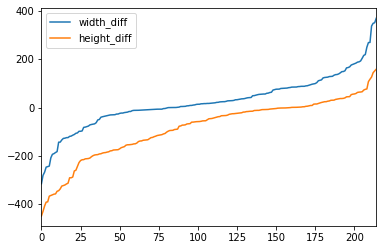

In [27]:
mean_size_diffs_v.sort_values('width_diff').reset_index().width_diff.plot(legend=True)
mean_size_diffs_v.sort_values('height_diff').reset_index().height_diff.plot(legend=True)

In [28]:
mean_size_diffs_v.describe()

,width_diff,height_diff
count,215.000000,215.000000
mean,24.649611,-83.549123
std,109.041796,123.288523
min,-315.142857,-448.750000
25%,-20.133333,-158.750000
50%,17.333333,-46.250000
75%,85.000000,1.000000
max,370.333333,159.333333


It may be wise to use that knowledge but first we must make sure that that works even if we take vertically oriented *predictions*, not *target frames*.

Let's check it out with predictions then!

In [29]:
sizes_v_pred = sizes[sizes.width < sizes.height]

In [30]:
mean_size_diffs_v_pred = sizes_v_pred.groupby('itemId').agg({
    'width_diff': 'mean',
    'height_diff': 'mean'
})

Seems that the tendency doesn't hold. It even seems to be reversed. Users underestimate width much more than height in vertically oriented frames.

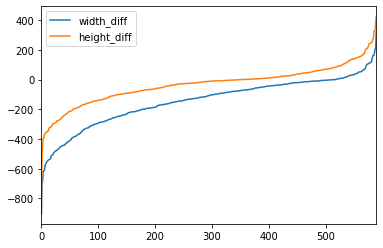

In [31]:
mean_size_diffs_v_pred.sort_values('width_diff').reset_index().width_diff.plot(legend=True)
mean_size_diffs_v_pred.sort_values('height_diff').reset_index().height_diff.plot(legend=True)

In [32]:
mean_size_diffs_v_pred.describe()

,width_diff,height_diff
count,590.000000,590.000000
mean,-144.255834,-32.913323
std,163.184639,128.953868
min,-904.000000,-809.000000
25%,-235.250000,-93.375000
50%,-107.300000,-12.000000
75%,-22.150000,30.150000
max,320.500000,427.000000


#### Step 10

To go with horizontally oriented frames now. Again, we start with splitting by *target frames*.

In [33]:
sizes_h = sizes[sizes.width_t > sizes.height_t]

In [34]:
mean_size_diffs_h = sizes_h.groupby('itemId').agg({
    'width_diff': 'mean',
    'height_diff': 'mean'
})

Width is slightly more underestimated in horizontally oriented frames.

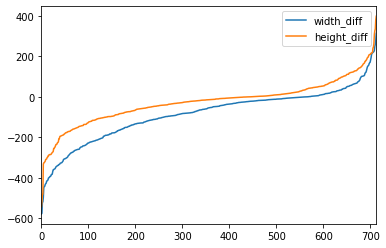

In [35]:
mean_size_diffs_h.sort_values('width_diff').reset_index().width_diff.plot(legend=True)
mean_size_diffs_h.sort_values('height_diff').reset_index().height_diff.plot(legend=True)

In [36]:
mean_size_diffs_v_pred.describe()

,width_diff,height_diff
count,590.000000,590.000000
mean,-144.255834,-32.913323
std,163.184639,128.953868
min,-904.000000,-809.000000
25%,-235.250000,-93.375000
50%,-107.300000,-12.000000
75%,-22.150000,30.150000
max,320.500000,427.000000


But once again, let's check whether this remains true for the data split by *predicted frames*.

In [37]:
sizes_h_pred = sizes[sizes.width > sizes.height]

In [38]:
mean_size_diffs_h_pred = sizes_h_pred.groupby('itemId').agg({
    'width_diff': 'mean',
    'height_diff': 'mean'
})

The level of underestimation is almost the same for both width and height. There are also extreme negative spikes.

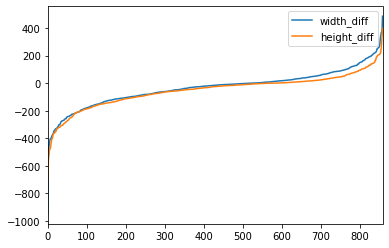

In [39]:
mean_size_diffs_h_pred.sort_values('width_diff').reset_index().width_diff.plot(legend=True)
mean_size_diffs_h_pred.sort_values('height_diff').reset_index().height_diff.plot(legend=True)

In [40]:
mean_size_diffs_h_pred.describe()

,width_diff,height_diff
count,860.000000,860.000000
mean,-33.123383,-52.349967
std,131.898148,121.196322
min,-950.000000,-692.000000
25%,-97.750000,-106.875000
50%,-15.400000,-24.750000
75%,33.050000,9.333333
max,486.250000,397.666667


#### Conclusion

Some predicted coordinates are less biased than others. Also, horizontal prediction errors seem to be greater than vertical.

Users tend to underestimate the size of the frame, and their errors with width and height are different for vertically and horizontally oriented frames.

#### Ideas for further research and application

* find the direction of users' prediction bias (maybe even for each user separately or for groups of users)
* try to predict the size of the frame and build it from the center of the least biased boundary
* look at how the innermost and outermost predicted boundaries deviate from the target boundaries

### EDA: Trusted and non-trusted users

Let's research the reliability of predictions provided by different users.

#### Step 0

Is it even worth exploring? How many users from the train data are also in the test data?

In [41]:
unique_train_users = votes.userId.unique()
unique_test_users = questions.userId.unique()
unique_common_users = list(set(unique_train_users).intersection(unique_test_users))
unique_users_intersection = len(unique_common_users)
unique_users_intersection

1001

Which is almost 84% of all test data users. Nice.

In [42]:
unique_users_intersection / len(unique_test_users)

0.839765100671141

#### Step 1

Use `coords` from the previous section, group it by `userId` and `itemId` and calculate distances between each user's prediction and target value for central point, X and Y means, and separate boundaries.

In [43]:
def calculate_distances(group):
    group['x1_distance'] = abs(group.x1 - group.x1_t)
    group['x2_distance'] = abs(group.x2 - group.x2_t)
    group['y1_distance'] = abs(group.y1 - group.y1_t)
    group['y2_distance'] = abs(group.y2 - group.y2_t)
    group['x_distance'] = abs(group.mean_x - group.mean_x_t)
    group['y_distance'] = abs(group.mean_y - group.mean_y_t)
    group['distance'] = np.sqrt(
        (group.mean_x - group.mean_x_t)**2 +
        (group.mean_y - group.mean_y_t)**2
    )
    
    return group

In [44]:
users_distances = coords.groupby(['userId', 'itemId'], as_index=False).apply(calculate_distances)

#### Step 2

Now get rid of unneeded columns and get `mean` values for every kind of distance for every user.

Also, I will add `distance_rounded` to group data more easily.

In [45]:
users_distances_only = users_distances.drop(columns=[
    'x1', 'x2', 'y1', 'y2', 'x1_t', 'x2_t', 'y1_t', 'y2_t',
    'mean_x', 'mean_y', 'mean_x_t', 'mean_y_t'
])

In [46]:
users_mean_distances = users_distances_only.groupby('userId', as_index=False).agg({
    'itemId': 'count',
    'x1_distance': 'mean',
    'x2_distance': 'mean',
    'y1_distance': 'mean',
    'y2_distance': 'mean',
    'x_distance': 'mean',
    'y_distance': 'mean',
    'distance': 'mean'
}).rename(columns={
    'itemId': 'howMany'
})

users_mean_distances['distance_rounded'] = users_mean_distances.distance.div(10).round().mul(10)

#### Step 3

Let's see what insights we can extract.

First, the distance bias distribution is unimodal, most observations fall under the distance error of 100 units. It may be a good idea to mark users with mean distance less than 100 (or up to, say, 150) as trusted ones and to use only their predictions when possible.

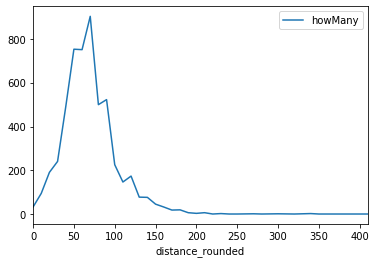

In [47]:
users_mean_distances.groupby('distance_rounded').agg({ 'howMany': 'sum' }).plot()

Second, some predictions have the same central and mean coordinates as the target ones (though they don't necessary match exact boundaries as separate coordinates may be equidistant from center and mean positions).

In [48]:
users_mean_distances.sort_values('distance').head()

,userId,howMany,x1_distance,x2_distance,y1_distance,y2_distance,x_distance,y_distance,distance,distance_rounded
1251,1609,1,0.0,0.0,5.0,5.0,0.0,0.0,0.000000,0.0
30,41,1,1.0,1.0,1.0,1.0,0.0,0.0,0.000000,0.0
59,77,1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1195,1539,1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
943,1230,1,1.0,1.0,2.0,1.0,1.0,0.5,1.118034,0.0


Third, the chart below shows how mean distance changes over *n* first predictions (in the set sorted by distance, ascending).

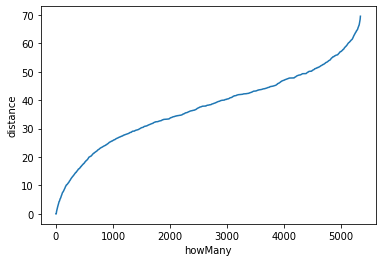

In [49]:
users_mean_distances_sorted = users_mean_distances.sort_values('distance')

sns.lineplot(
    x=users_mean_distances_sorted.howMany.expanding().sum(),
    y=users_mean_distances_sorted.distance.expanding().mean()
)

#### Conclusion

Most predictions are rather accurate but there are spikes which must be explored more deeply.

#### Ideas for further research and application

* try to find exact users whose predictions are less accurate than those of others
    * are they the same from prediction to prediction?
    * are there "mixed" users with both very good and very bad predictions?